# KTR Pyro Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.ktr import KTRFull, KTRAggregated, KTRMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## VI Fit and Predict - Fully Bayesian

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [7]:
ktr_vi = KTRFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=2,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = 10,
    regressor_knot_loc=[0] * 3,
    regressor_knot_scale=[1] * 3,
    positive_regressor_knot_pooling_scale=0.1,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    n_bootstrap_draws=200,
    estimator_type=PyroEstimatorVI,
)

In [8]:
%%time
ktr_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 1.7656e+05, scale = 0.11889
step  100 loss = 15882, scale = 0.76248
step  200 loss = -74.194, scale = 0.32617
step  300 loss = -94.013, scale = 0.40115
step  400 loss = -96.92, scale = 0.40394
step  500 loss = -97.023, scale = 0.41579
step  600 loss = -97.851, scale = 0.39676
step  700 loss = -97.589, scale = 0.40445
step  800 loss = -97.77, scale = 0.39383
step  900 loss = -94.892, scale = 0.39566
CPU times: user 2min 52s, sys: 3.85 s, total: 2min 56s
Wall time: 16.3 s


In [9]:
predicted_df = ktr_vi.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.13995,12.38675,12.62206
1,2017-07-09,12.15624,12.41874,12.62569
2,2017-07-16,12.05869,12.30243,12.56901
3,2017-07-23,12.00216,12.25623,12.49863
4,2017-07-30,12.05523,12.31076,12.52767


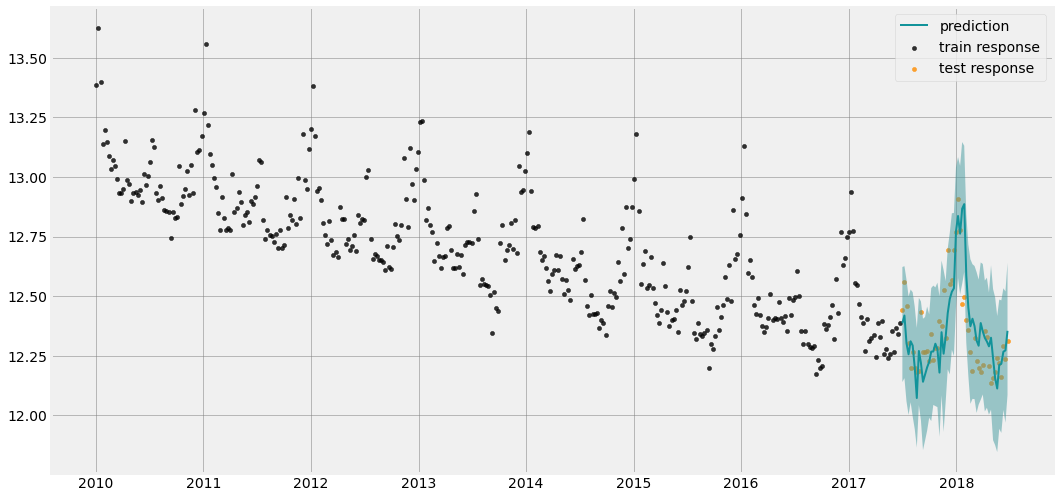

In [10]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [11]:
coef_df = ktr_vi.get_regression_coefs(aggregate_method='mean')
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.34897,1.02551,0.11988
1,2010-01-10,0.35282,1.01941,0.11961
2,2010-01-17,0.35672,1.01324,0.11933
3,2010-01-24,0.36067,1.00700,0.11905
4,2010-01-31,0.36468,1.00071,0.11876


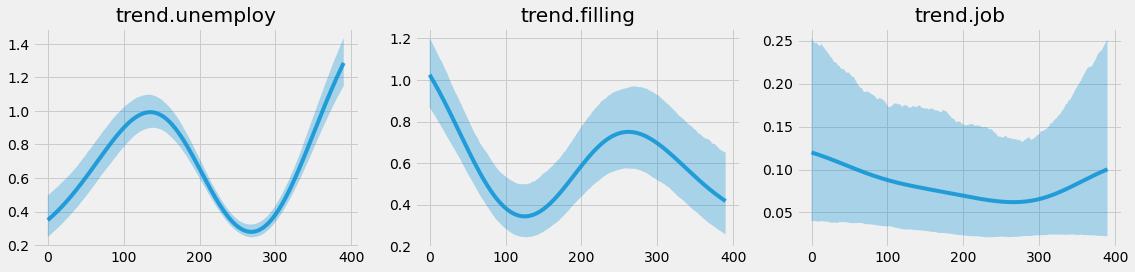

In [12]:
_ = ktr_vi.plot_regression_coefs(ncol=3, figsize=(16, 4), include_ci=True)

## VI Fit and Predict - Aggregated

In [13]:
ktr_vi_agg = KTRAggregated(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=2,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = 10,
    regressor_knot_loc=[0] * 3,
    regressor_knot_scale=[1] * 3,
    positive_regressor_knot_pooling_scale=0.1,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=False,
    message=100,
    aggregate_method='median',
    estimator_type=PyroEstimatorVI,
)

In [14]:
%%time
ktr_vi_agg.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


CPU times: user 2min 56s, sys: 5.03 s, total: 3min 1s
Wall time: 17.1 s


In [15]:
predicted_df = ktr_vi_agg.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52,regression
0,2017-07-02,12.36981,12.12171,0.00006,0.24805
1,2017-07-09,12.40685,12.12003,0.01512,0.27170
2,2017-07-16,12.32290,12.11849,0.00553,0.19887
3,2017-07-23,12.26623,12.11707,-0.01712,0.16627
4,2017-07-30,12.30188,12.11577,-0.01215,0.19826


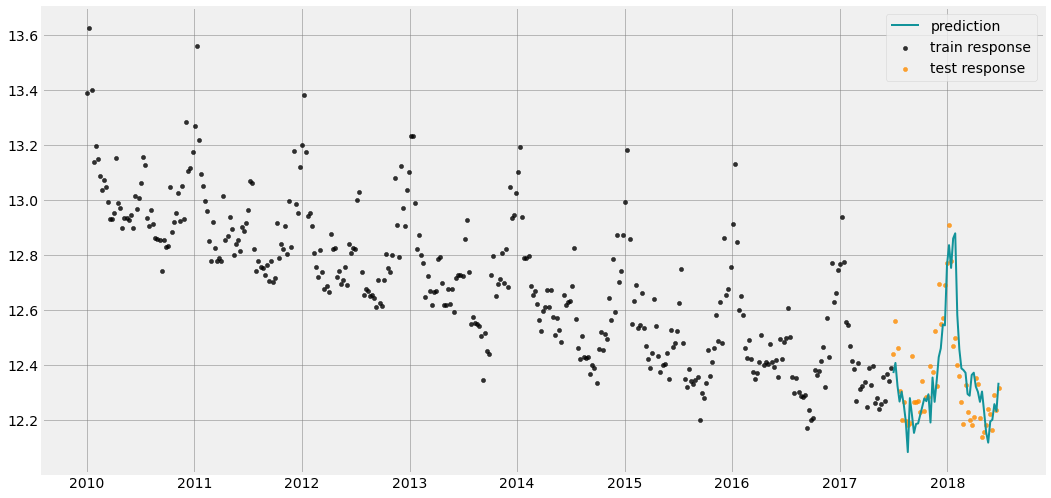

In [16]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [17]:
coef_df = ktr_vi_agg.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.32408,1.01327,0.09156
1,2010-01-10,0.32803,1.00706,0.09132
2,2010-01-17,0.33204,1.00078,0.09107
3,2010-01-24,0.33610,0.99444,0.09083
4,2010-01-31,0.34021,0.98804,0.09058


In [18]:
# extract future coefficients
coef_df2 = ktr_vi_agg.get_regression_coefs(date_array=test_df['week'])
coef_df2.head()

,week,trend.unemploy,trend.filling,trend.job
0,2017-07-02,1.29012,0.37941,0.06771
1,2017-07-09,1.29910,0.37698,0.06796
2,2017-07-16,1.30799,0.37458,0.06820
3,2017-07-23,1.31677,0.37220,0.06844
4,2017-07-30,1.32546,0.36987,0.06868


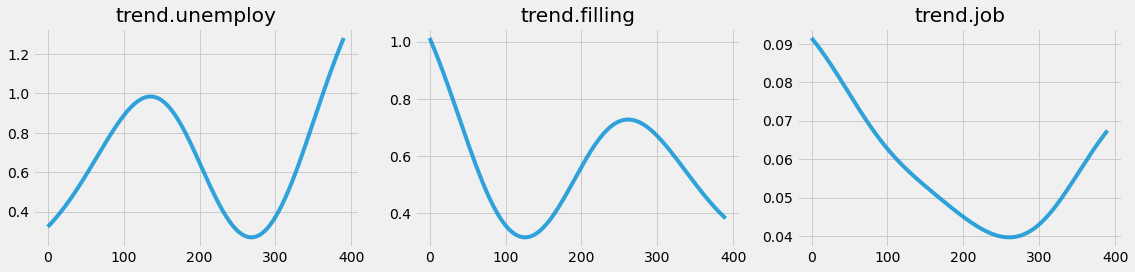

In [19]:
_ = ktr_vi_agg.plot_regression_coefs(ncol=3, figsize=(16, 4))

## VI Fit and Predict - Aggregated

In [20]:
ktr_map = KTRMAP(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=2,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] *3,
    
    level_knot_scale = 10,
    regressor_knot_loc=[0] * 3,
    regressor_knot_scale=[1] * 3,
    positive_regressor_knot_pooling_scale=0.1,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    learning_rate=0.1,
    verbose=False,
    message=100,
    estimator_type=PyroEstimatorMAP,
)

In [21]:
%%time
ktr_map.fit(df=train_df)

CPU times: user 23.5 s, sys: 332 ms, total: 23.8 s
Wall time: 4.02 s


In [22]:
predicted_df = ktr_map.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52,regression
0,2017-07-02,12.38967,12.08413,0.05438,0.25117
1,2017-07-09,12.41594,12.08248,0.05933,0.27412
2,2017-07-16,12.25273,12.08097,-0.02704,0.19879
3,2017-07-23,12.15936,12.07958,-0.08651,0.16629
4,2017-07-30,12.23398,12.07830,-0.04006,0.19574


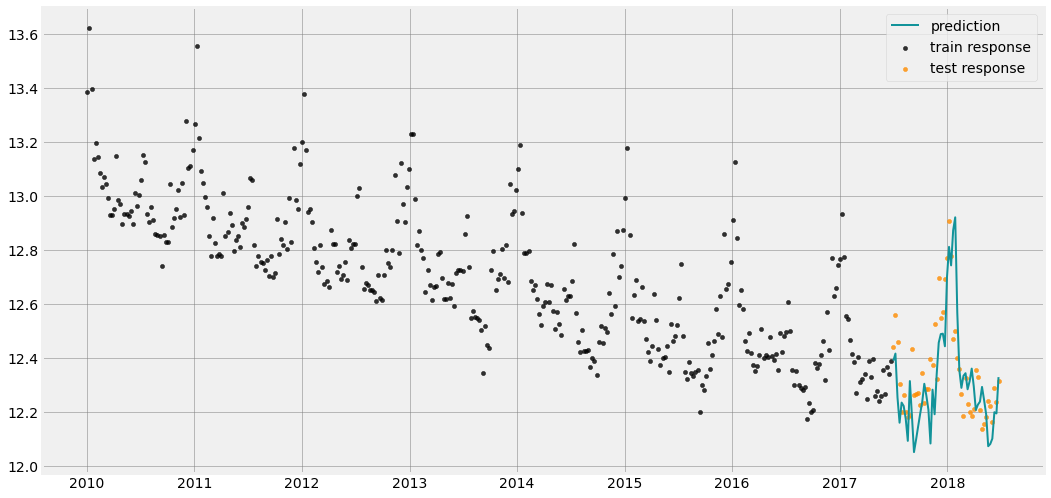

In [23]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [24]:
coef_df = ktr_map.get_regression_coefs()
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.26053,0.18712,0.00000
1,2010-01-10,0.26525,0.18963,0.00000
2,2010-01-17,0.27004,0.19216,0.00000
3,2010-01-24,0.27490,0.19470,0.00000
4,2010-01-31,0.27981,0.19725,0.00000


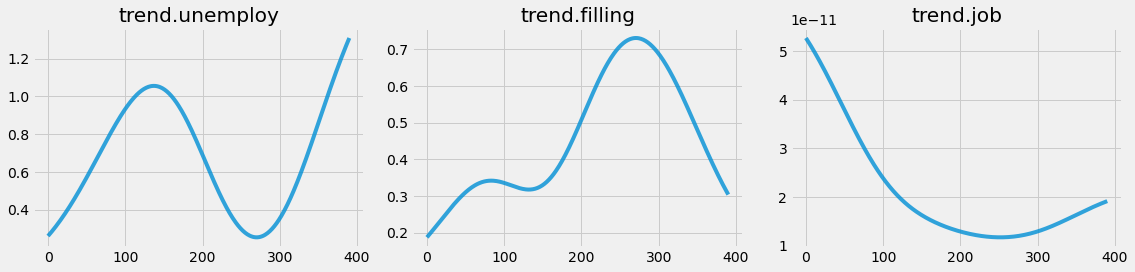

In [25]:
_ = ktr_map.plot_regression_coefs(ncol=3, figsize=(16, 4))

## hyper-parameter tuning

In [26]:
from orbit.diagnostics.backtest import GridSearchOrbit
from orbit.diagnostics.metrics import smape, mape, wmape

In [27]:
# param_grid = {'num_steps': [100, 1000]}

param_grid = {'span_level': [0.1, 0.2], 'span_coefficients': [0.2, 0.3],
              'rho_level': [0.05, 0.1], 'rho_coefficients': [0.15, 0.2]}

In [28]:
best_params, tuned_df = GridSearchOrbit(param_grid, 
                                        model=ktr_map, 
                                        df=df,
                                        min_train_len=100, incremental_len=100, forecast_len=20, 
                                        metrics=None, criteria=None, verbose=True)

100%|██████████| 16/16 [03:37<00:00, 13.58s/it]


In [29]:
tuned_df

,rho_coefficients,rho_level,span_coefficients,span_level,metrics
0,0.15000,0.05000,0.20000,0.10000,0.01166
1,0.15000,0.05000,0.20000,0.20000,0.01197
2,0.15000,0.05000,0.30000,0.10000,0.01080
3,0.15000,0.05000,0.30000,0.20000,0.01116
4,0.15000,0.10000,0.20000,0.10000,0.01186
5,0.15000,0.10000,0.20000,0.20000,0.01152
6,0.15000,0.10000,0.30000,0.10000,0.01291
7,0.15000,0.10000,0.30000,0.20000,0.01082
8,0.20000,0.05000,0.20000,0.10000,0.01145
9,0.20000,0.05000,0.20000,0.20000,0.01165


In [30]:
best_params

[{'rho_coefficients': 0.15,
  'rho_level': 0.05,
  'span_coefficients': 0.3,
  'span_level': 0.1}]